In [150]:
from langchain_ollama import ChatOllama 
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Optional, Annotated
from pydantic import BaseModel, Field
# import operator

In [151]:
model = ChatOllama(model = "llama3.2:3b")

In [152]:
class SentimentSchema(BaseModel):
    
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')
    

In [153]:
class DiagnosisSchema(BaseModel):

    issue_type: Literal['UX', 'Performance', 'Bug', 'Support', 'Other'] = Field(description='The category of the issue mentioned in the review.')
    tone: Literal['angry', 'frustated', 'disappointed', 'calm'] = Field(description = 'The emotional tone expressed by the user.')
    urgent: Literal['low','medium', 'high'] = Field(description = 'How urgent or critical the issue appears to be')

In [154]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [155]:
# prompt = "What is the sentiment of the following review - The Software is too good!"
# structured_model.invoke(prompt).sentiment

In [166]:
# Create a state 
class ReviewState(TypedDict , total = False):

    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

    # reply: str
    # issue_type: str
    # urgency: str
    # positive_response: str
    # negative_response: str

    

In [ ]:
# create a function for find_sentiment
def find_sentiment(state: ReviewState):

    prompt = f"You are a professional reviews analyser for a top MNC and your only and crucial job is to extract the sentiment of the following review provided by the user: {state["review"]}"

    sentiment = structured_model.invoke(prompt).sentiment
    
    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'posiitve':
        return 'positive_response'
    elif state['sentiment'] == 'negative':
        return 'run_diagnosis'

In [158]:
# #  Create a graph
# graph = StateGraph(ReviewState)

# # add nodes 
# graph.add_node("find_sentiment", find_sentiment)

# # add edges
# graph.add_edge(START, "find_sentiment")
# graph.add_edge("find_sentiment", END)

# workflow = graph.compile()

In [159]:
# initial_state ={
#     'review': "This is a very good smartphone and i love it!"
# }
# final_state = workflow.invoke(initial_state)
# print(final_state)

In [160]:
#  Create a function to write a positive response to the user's review
def positive_response(state: ReviewState):

    prompt = f"You are a professional responser to positive reviews given by the user to a top MNC, your only job is to return a positive response for this review: \n {state["review"]} \n Also kindly ask the user to leave feedback to our website"

    response = model.invoke(prompt).content

    return {'response': response}

In [161]:
#  Create a function to run diagnosis for a negative response and give the parameters results
def run_diagnosis(state: ReviewState):

    prompt = f"You are a professional Diagnoser of the negative reviews that users give to a top MNC, your only job is to run a thorough diagnosis and return necessary details like 'issue_type', 'tone' and 'urgency' from the following review: \n{state['review']}"

    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

In [162]:
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']
    prompt = f"You are a professional Negative reviews responser for a top MNC, your only job is to repond to the user by giving them an empathetic, helpful resolution message. The user had a {diagnosis['issue_type']} issue, sounded '{diagnosis['tone']}, and marked urgency as {diagnosis['urgent']}."

    response = model.invoke(prompt).content

    return {'response' : response}

In [163]:
#  Create a graph
graph = StateGraph(ReviewState)

# add nodes 
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)
graph.add_node("positive_response", positive_response)


# Add edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
# No need for this 
# graph.add_conditional_edges("find_sentiment", "positive_response")
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)



# Compile 
workflow = graph.compile()


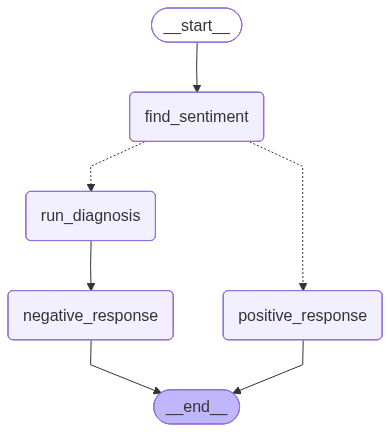

In [164]:
workflow

In [165]:
initial_state = {
    'review' : 'The Pixel 7a is widely praised as one of the best mid-range Android phones available. It brings the powerful Tensor G2 chip—the same used in Google’s higher-end models—to a more affordable price point, enabling smooth everyday performance and AI-enhanced features. The camera quality stands out for its class, often outperforming competitors at similar price levels, with excellent still photos and capable 4K video recording. The clean Pixel software experience, future updates, and polished UI make it feel lightweight and responsive. Many reviewers and users highlight the impressive balance of performance, camera capability, and software polish in a compact form factor.'
}

workflow.invoke(initial_state)

KeyError: None

In [100]:
initial_state = {
    'review' : 'Despite its strengths, the Pixel 7a has some notable drawbacks that frustrate certain users. The battery life is often described as average or underwhelming, especially under heavier usage like gaming or extended video viewing—some report only moderate screen-on times and warming during demanding tasks. The display refresh rate at 90 Hz is good but not class-leading, and the device’s plasticky build and occasional performance jitters have disappointed users compared to competitors with more refined materials or smoother overall performance. Additionally, some user-reported issues like inconsistent longevity and battery concerns have surfaced online.'
}

workflow.invoke(initial_state)

{'review': 'Despite its strengths, the Pixel 7a has some notable drawbacks that frustrate certain users. The battery life is often described as average or underwhelming, especially under heavier usage like gaming or extended video viewing—some report only moderate screen-on times and warming during demanding tasks. The display refresh rate at 90 Hz is good but not class-leading, and the device’s plasticky build and occasional performance jitters have disappointed users compared to competitors with more refined materials or smoother overall performance. Additionally, some user-reported issues like inconsistent longevity and battery concerns have surfaced online.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'calm',
  'urgent': 'medium'},
 'response': 'Here\'s a potential response:\n\n"Dear [User],\n\nI\'m so sorry to hear that you\'re experiencing performance issues with our product/service. I can imagine how frustrating that must be for you, especial